# IBM AI Enterprise Workflow Capstone Project - Part 1

## Data preparation

In [1]:
#!/usr/bin/env python
"""
collection of functions for the final case study solution
"""

import os
import sys
import re
import shutil
import time
import pickle
from collections import defaultdict
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

COLORS = ["darkorange","royalblue","slategrey"]

def fetch_data(data_dir):
    """
    laod all json formatted files into a dataframe
    """

    ## input testing
    if not os.path.isdir(data_dir):
        raise Exception("specified data dir does not exist")
    if not len(os.listdir(data_dir)) > 0:
        raise Exception("specified data dir does not contain any files")

    file_list = [os.path.join(data_dir,f) for f in os.listdir(data_dir) if re.search("\.json",f)]
    correct_columns = ['country', 'customer_id', 'day', 'invoice', 'month',
                       'price', 'stream_id', 'times_viewed', 'year']

    ## read data into a temp structure
    all_months = {}
    for file_name in file_list:
        df = pd.read_json(file_name)
        all_months[os.path.split(file_name)[-1]] = df

    ## ensure the data are formatted with correct columns
    for f,df in all_months.items():
        cols = set(df.columns.tolist())
        if 'StreamID' in cols:
             df.rename(columns={'StreamID':'stream_id'},inplace=True)
        if 'TimesViewed' in cols:
            df.rename(columns={'TimesViewed':'times_viewed'},inplace=True)
        if 'total_price' in cols:
            df.rename(columns={'total_price':'price'},inplace=True)

        cols = df.columns.tolist()
        if sorted(cols) != correct_columns:
            raise Exception("columns name could not be matched to correct cols")

    ## concat all of the data
    df = pd.concat(list(all_months.values()),sort=True)
    years,months,days = df['year'].values,df['month'].values,df['day'].values 
    dates = ["{}-{}-{}".format(years[i],str(months[i]).zfill(2),str(days[i]).zfill(2)) for i in range(df.shape[0])]
    df['invoice_date'] = np.array(dates,dtype='datetime64[D]')
    df['invoice'] = [re.sub("\D+","",i) for i in df['invoice'].values]
    
    ## sort by date and reset the index
    df.sort_values(by='invoice_date',inplace=True)
    df.reset_index(drop=True,inplace=True)
    
    return(df)


def convert_to_ts(df_orig, country=None):
    """
    given the original DataFrame (fetch_data())
    return a numerically indexed time-series DataFrame 
    by aggregating over each day
    """

    if country:
        if country not in np.unique(df_orig['country'].values):
            raise Excpetion("country not found")
    
        mask = df_orig['country'] == country
        df = df_orig[mask]
    else:
        df = df_orig
        
    ## use a date range to ensure all days are accounted for in the data
    invoice_dates = df['invoice_date'].values
    start_month = '{}-{}'.format(df['year'].values[0],str(df['month'].values[0]).zfill(2))
    stop_month = '{}-{}'.format(df['year'].values[-1],str(df['month'].values[-1]).zfill(2))
    df_dates = df['invoice_date'].values.astype('datetime64[D]')
    days = np.arange(start_month,stop_month,dtype='datetime64[D]')
    
    purchases = np.array([np.where(df_dates==day)[0].size for day in days])
    invoices = [np.unique(df[df_dates==day]['invoice'].values).size for day in days]
    streams = [np.unique(df[df_dates==day]['stream_id'].values).size for day in days]
    views =  [df[df_dates==day]['times_viewed'].values.sum() for day in days]
    revenue = [df[df_dates==day]['price'].values.sum() for day in days]
    year_month = ["-".join(re.split("-",str(day))[:2]) for day in days]

    df_time = pd.DataFrame({'date':days,
                            'purchases':purchases,
                            'unique_invoices':invoices,
                            'unique_streams':streams,
                            'total_views':views,
                            'year_month':year_month,
                            'revenue':revenue})
    return(df_time)


def fetch_ts(data_dir, clean=False):
    """
    convenience function to read in new data
    uses csv to load quickly
    use clean=True when you want to re-create the files
    """

    ts_data_dir = os.path.join(data_dir,"ts-data")
    
    if clean:
        shutil.rmtree(ts_data_dir)
    if not os.path.exists(ts_data_dir):
        os.mkdir(ts_data_dir)

    ## if files have already been processed load them        
    if len(os.listdir(ts_data_dir)) > 0:
        print("... loading ts data from files")
        return({re.sub("\.csv","",cf)[3:]:pd.read_csv(os.path.join(ts_data_dir,cf)) for cf in os.listdir(ts_data_dir)})

    ## get original data
    print("... processing data for loading")
    df = fetch_data(data_dir)

    ## find the top ten countries (wrt revenue)
    table = pd.pivot_table(df,index='country',values="price",aggfunc='sum')
    table.columns = ['total_revenue']
    table.sort_values(by='total_revenue',inplace=True,ascending=False)
    top_ten_countries =  np.array(list(table.index))[:10]

    file_list = [os.path.join(data_dir,f) for f in os.listdir(data_dir) if re.search("\.json",f)]
    countries = [os.path.join(data_dir,"ts-"+re.sub("\s+","_",c.lower()) + ".csv") for c in top_ten_countries]

    ## load the data
    dfs = {}
    dfs['all'] = convert_to_ts(df)
    for country in top_ten_countries:
        country_id = re.sub("\s+","_",country.lower())
        file_name = os.path.join(data_dir,"ts-"+ country_id + ".csv")
        dfs[country_id] = convert_to_ts(df,country=country)

    ## save the data as csvs    
    for key, item in dfs.items():
        item.to_csv(os.path.join(ts_data_dir,"ts-"+key+".csv"),index=False)
        
    return(dfs)

def engineer_features(df,training=True):
    """
    for any given day the target becomes the sum of the next days revenue
    for that day we engineer several features that help predict the summed revenue
    
    the 'training' flag will trim data that should not be used for training
    when set to false all data will be returned

    """

    ## extract dates
    dates = df['date'].values.copy()
    dates = dates.astype('datetime64[D]')

    ## engineer some features
    eng_features = defaultdict(list)
    previous =[7, 14, 28, 70]  #[7, 14, 21, 28, 35, 42, 49, 56, 63, 70]
    y = np.zeros(dates.size)
    for d,day in enumerate(dates):

        ## use windows in time back from a specific date
        for num in previous:
            current = np.datetime64(day, 'D') 
            prev = current - np.timedelta64(num, 'D')
            mask = np.in1d(dates, np.arange(prev,current,dtype='datetime64[D]'))
            eng_features["previous_{}".format(num)].append(df[mask]['revenue'].sum())

        ## get get the target revenue    
        plus_30 = current + np.timedelta64(30,'D')
        mask = np.in1d(dates, np.arange(current,plus_30,dtype='datetime64[D]'))
        y[d] = df[mask]['revenue'].sum()

        ## attempt to capture monthly trend with previous years data (if present)
        start_date = current - np.timedelta64(365,'D')
        stop_date = plus_30 - np.timedelta64(365,'D')
        mask = np.in1d(dates, np.arange(start_date,stop_date,dtype='datetime64[D]'))
        eng_features['previous_year'].append(df[mask]['revenue'].sum())

        ## add some non-revenue features
        minus_30 = current - np.timedelta64(30,'D')
        mask = np.in1d(dates, np.arange(minus_30,current,dtype='datetime64[D]'))
        eng_features['recent_invoices'].append(df[mask]['unique_invoices'].mean())
        eng_features['recent_views'].append(df[mask]['total_views'].mean())

    X = pd.DataFrame(eng_features)
    ## combine features in to df and remove rows with all zeros
    X.fillna(0,inplace=True)
    mask = X.sum(axis=1)>0
    X = X[mask]
    y = y[mask]
    dates = dates[mask]
    X.reset_index(drop=True, inplace=True)

    if training == True:
        ## remove the last 30 days (because the target is not reliable)
        mask = np.arange(X.shape[0]) < np.arange(X.shape[0])[-30]
        X = X[mask]
        y = y[mask]
        dates = dates[mask]
        X.reset_index(drop=True, inplace=True)
    
    return(X,y,dates)

In [2]:
run_start = time.time() 
data_dir = os.path.join("..","cs-train")
print("...fetching data")

ts_all = fetch_ts(data_dir,clean=False)

m, s = divmod(time.time()-run_start,60)
h, m = divmod(m, 60)
print("load time:", "%d:%02d:%02d"%(h, m, s))

for key,item in ts_all.items():
    print(key,item.shape)

...fetching data
... loading ts data from files
load time: 0:00:00
portugal (607, 7)
united_kingdom (607, 7)
hong_kong (426, 7)
eire (607, 7)
spain (607, 7)
france (607, 7)
singapore (456, 7)
all (607, 7)
norway (577, 7)
germany (607, 7)
netherlands (607, 7)


In [3]:
ts_all["all"].head()

,date,purchases,unique_invoices,unique_streams,total_views,year_month,revenue
0,2017-11-01,0,0,0,0,2017-11,0.0
1,2017-11-02,0,0,0,0,2017-11,0.0
2,2017-11-03,0,0,0,0,2017-11,0.0
3,2017-11-04,0,0,0,0,2017-11,0.0
4,2017-11-05,0,0,0,0,2017-11,0.0


In [4]:
countries = []
for k in ts_all.keys():
    countries.append(k)
countries

['portugal',
 'united_kingdom',
 'hong_kong',
 'eire',
 'spain',
 'france',
 'singapore',
 'all',
 'norway',
 'germany',
 'netherlands']

## Revenue Analysis

### Revenue per day

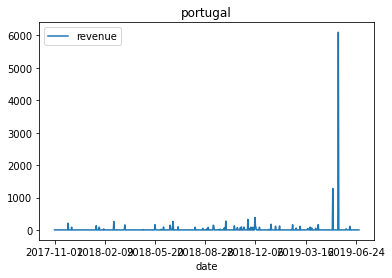

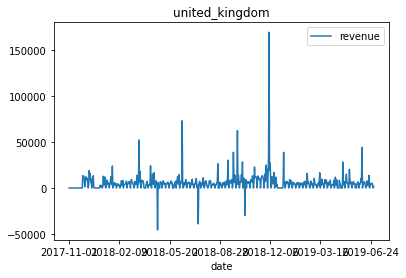

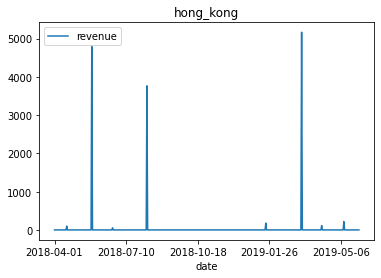

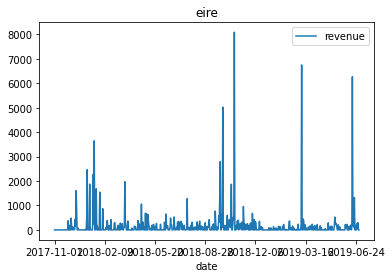

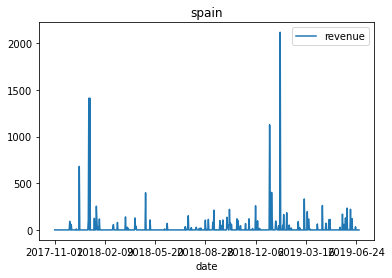

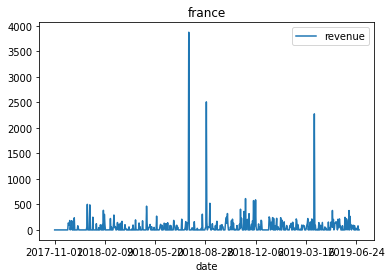

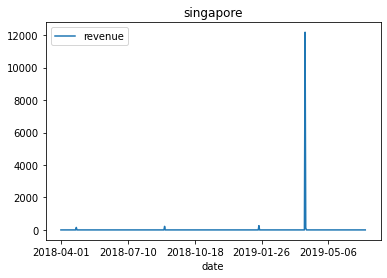

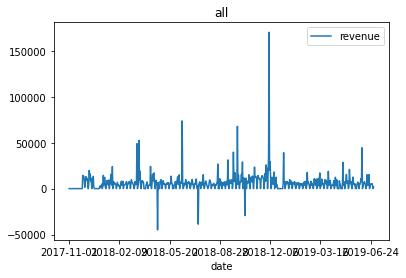

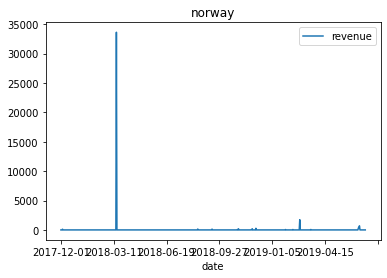

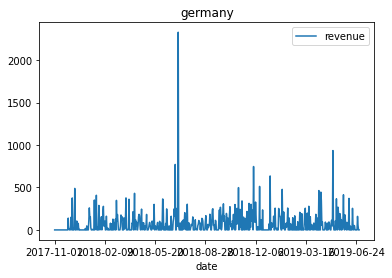

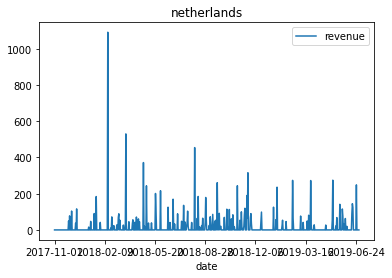

In [5]:
for country in countries:
    ts_all[country].plot(x="date", y="revenue", title=country)

### Revenue per month

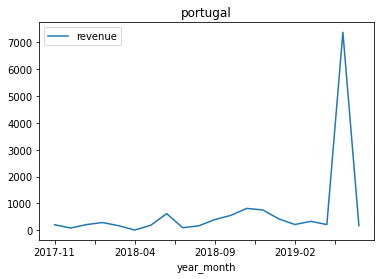

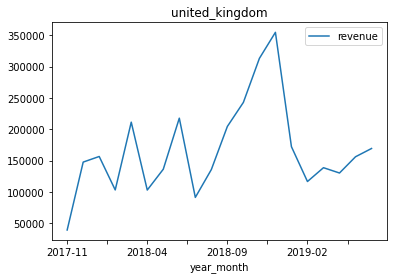

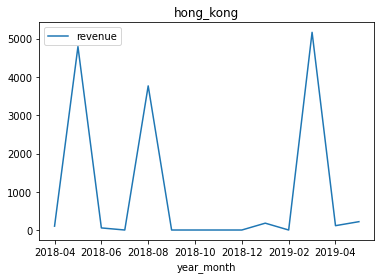

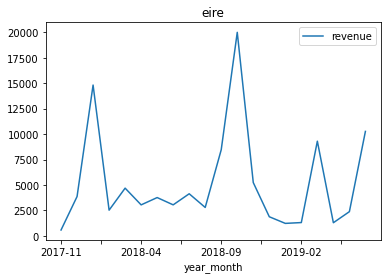

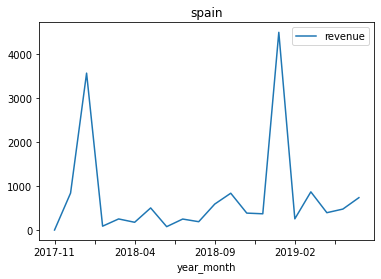

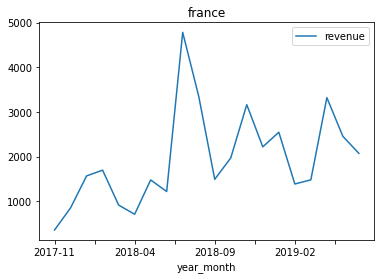

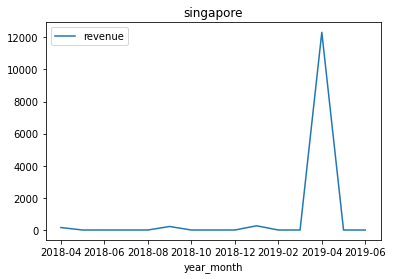

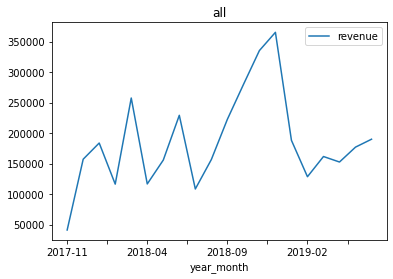

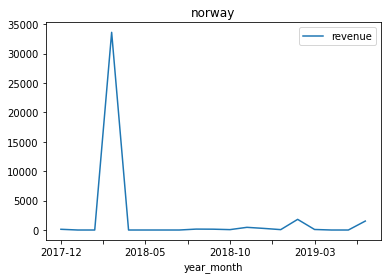

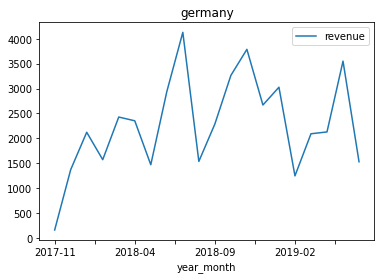

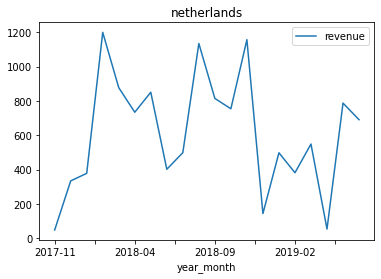

In [6]:
for country in countries:
    ts_all[country].groupby("year_month").agg({"revenue": "sum"}).plot(title=country)

## Relationship between the relevant data and target

In [17]:
import seaborn as sns

In [14]:
df = ts_all["all"][["purchases", "unique_invoices", "unique_streams", "total_views", "revenue"]]
c = df.corr()

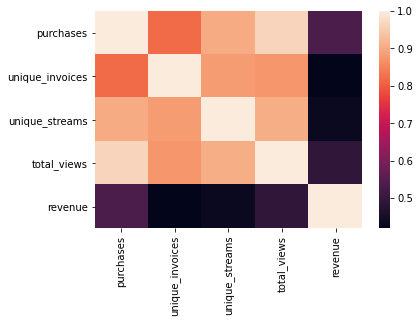

In [18]:
sns.heatmap(c)